# Dimensionality reduction of neural data using linear decomposition methods

Neural data is very high-dimensional but in many cases, there is underlying structure that embeds the data into lower dimensionality than the data. In this tutorial, we will contrive such a case using simulations, and then work through some fundamental methods for decomposition of the data. The methods that we will use will all be linear, meaning that they 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Neural data is often represented in dense multi-dimensional arrays 

In [2]:
n_neurons = 20 
duration_per_trial = 1  # sec
Fs = 1000  # Hz 
n_trials = 200
samples_per_trial = duration_per_trial * Fs
time = np.linspace(0, duration_per_trial, samples_per_trial)

In [3]:
neuron_factor_noise = 1
neuron_factor = np.zeros(n_neurons)
neuron_factor[:5] = 10 + np.random.randn(5) * neuron_factor_noise
neuron_factor[5:10] = -3 + np.random.randn(5) * neuron_factor_noise 
neuron_factor[10:15] = 4 + np.random.randn(5) * neuron_factor_noise
neuron_factor[15:] = -7 + np.random.randn(5) * neuron_factor_noise 

Text(0.5, 0, 'Neuron')

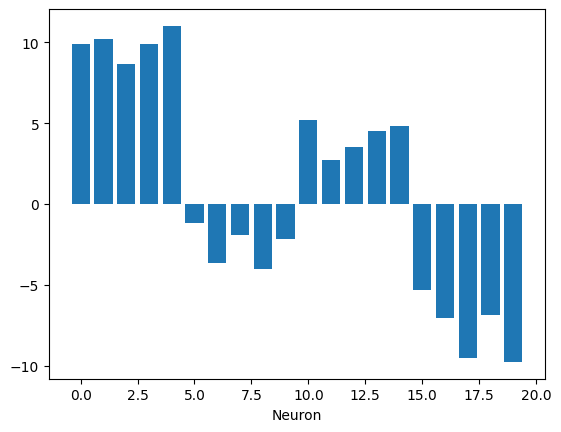

In [4]:
fig, ax = plt.subplots()
ax.bar(range(20), neuron_factor)
ax.set_xlabel("Neuron")

In [91]:
trial_factor1 = np.arange(n_trials, dtype=float)
trial_factor1 = trial_factor1 + np.random.randn(*trial_factor1.shape) * 5

In [93]:
trial_factor2 = np.arange(n_trials, dtype=float)
trial_factor2[100:] = trial_factor2[100] - np.arange(100) * 0.5 
trial_factor2 = trial_factor2 + np.random.randn(*trial_factor2.shape) * 5


Text(0.5, 0, 'Trial')

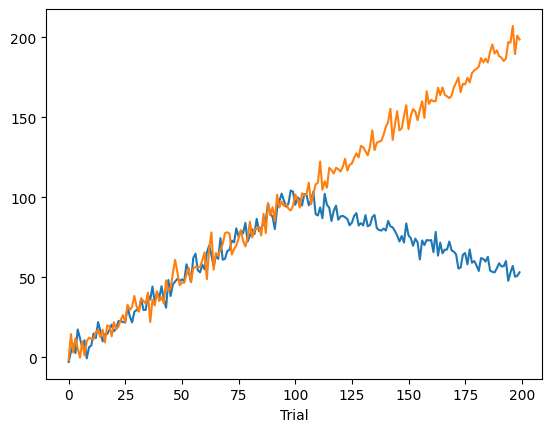

In [94]:
fig, ax = plt.subplots()
ax.plot(trial_factor2)
ax.plot(trial_factor1)
ax.set_xlabel("Trial")

In [163]:
freq1 = 4
phase1 = 0
freq2 = 2
phase2 = np.pi/2


In [164]:
time_factor1 = np.sin(freq1 * time + phase1) + 1
time_factor1 = time_factor1 + np.random.randn(*time_factor.shape) * 0.1
time_factor2 = np.sin(freq2 * time + phase2) + 1
time_factor2 = time_factor2 + np.random.randn(*time_factor.shape) * 0.1


Text(0.5, 0, 'Time (sec)')

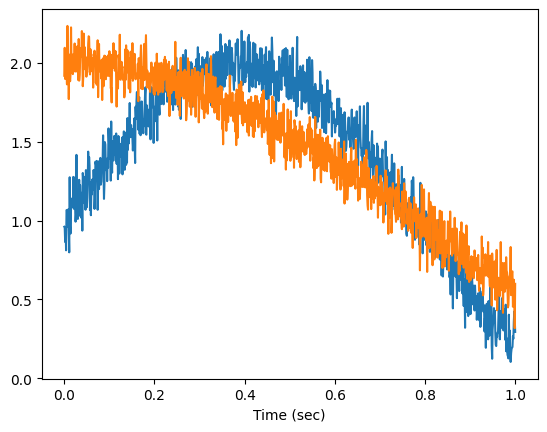

In [165]:
fig, ax = plt.subplots()
ax.plot(time, time_factor1)
ax.plot(time, time_factor2)
ax.set_xlabel("Time (sec)")

The simulated data in this case will be the *outer product* of the three factors. 


The outer product of two vectors, $\mathbf{u}$ and $\mathbf{v}$, is denoted by $\mathbf{u} \otimes \mathbf{v}$ and is defined as:

$$    
\begin{equation}
\mathbf{u} \otimes \mathbf{v} =
\begin{bmatrix}
u_1 \\
u_2 \\
\vdots \\
u_n
\end{bmatrix}
\begin{bmatrix}
v_1 & v_2 & \cdots & v_m
\end{bmatrix}
=
\begin{bmatrix}
u_1 v_1 & u_1 v_2 & \cdots & u_1 v_m \\
u_2 v_1 & u_2 v_2 & \cdots & u_2 v_m \\
\vdots & \vdots & \ddots & \vdots \\
u_n v_1 & u_n v_2 & \cdots & u_n v_m \\
\end{bmatrix}
\end{equation}
$$

Here, $\mathbf{u}$ is an $n$-dimensional column vector, $\mathbf{v}$ is an $m$-dimensional row vector, and $\mathbf{u} \otimes \mathbf{v}$ is an $n \times m$ matrix.

In numpy that can be implemented using standard matrix multiplication operations. Here, we add one trial factor to one part of the matrix and another trial_factor to the other part of the matrix

In [166]:
neuron_by_trial = neuron_factor[:, None] @ trial_factor1[None] 
neuron_by_trial[10:] = (neuron_factor[:, None] @ trial_factor2[None])[10:]

In [167]:
neuron_by_trial.shape

(20, 200)

Text(0, 0.5, 'Neuron')

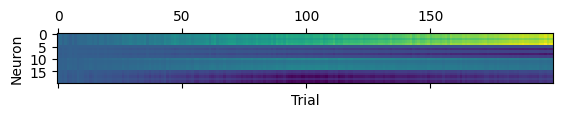

In [168]:
fig, ax = plt.subplots()
ax.matshow(neuron_by_trial)
ax.set_xlabel("Trial")
ax.set_ylabel("Neuron")

In [169]:
data = neuron_by_trial[:, :, None] @ time_factor1[None]
data[:10] = neuron_by_trial[:, :, None][:10] @ time_factor2[None]


Looking at two different neurons, we can see that different sub-populations of neurons change their behavior in distinct ways over time and and trials

Text(0, 0.5, 'Trial')

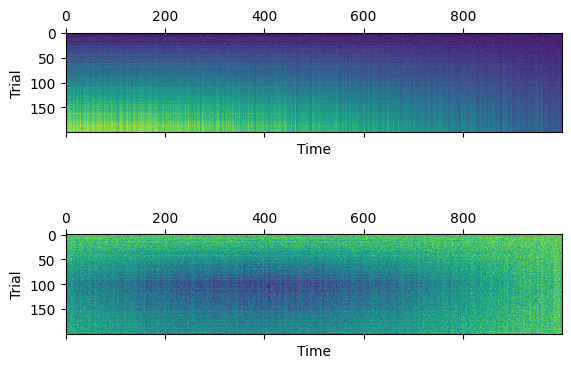

In [173]:
fig, ax = plt.subplots(2)
ax[0].matshow(data[0])
ax[1].matshow(data[15])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Trial")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Trial")


Many of the tools of linear algebra depend on working with data that is two-dimensional, so for now we will convert our three-way tensor (that's what it's called!) to a 2-way matrix. We'll come back to the 3-way tensor a little bit later.

# Trial-averaged PCA

Here, we will start with the first strategy, ignore the fact that there are across-trial dynamics and average on the second dimension.

In [174]:
trial_averaged_data = np.mean(data, 1)

In [175]:
trial_averaged_data.shape

(20, 1000)

Text(0, 0.5, 'Neuron')

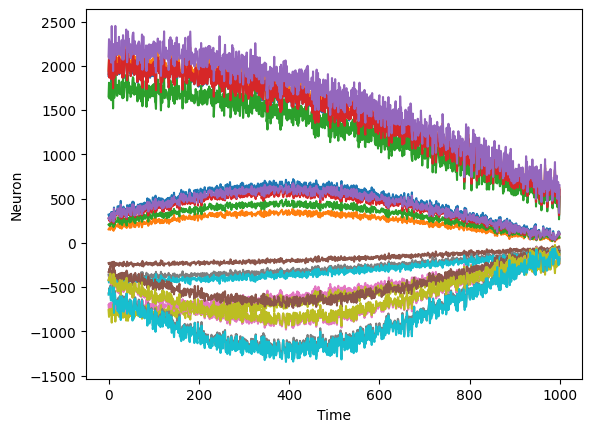

In [177]:
fig, ax = plt.subplots()
ax.plot(trial_averaged_data.T)
ax.set_xlabel("Time")
ax.set_ylabel("Neuron")

Our first tool for decomposing this matrix back into the components that generated it is the Singular Value Decomposition. This is a way to decompose a matrix into three different components that are informative:

In [178]:
U, S, V = np.linalg.svd(trial_averaged_data, full_matrices=False)

Where U and T are both unitary matrices (meaning that $U U^t = I$ and $V V^t = I$)

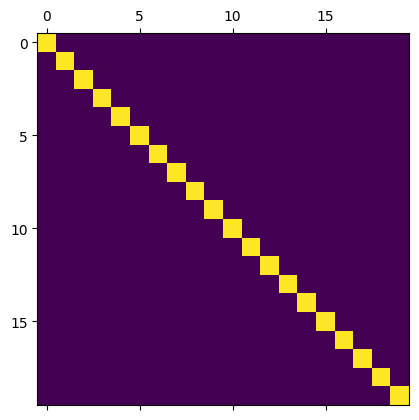

In [179]:
plt.matshow(U @ U.T)

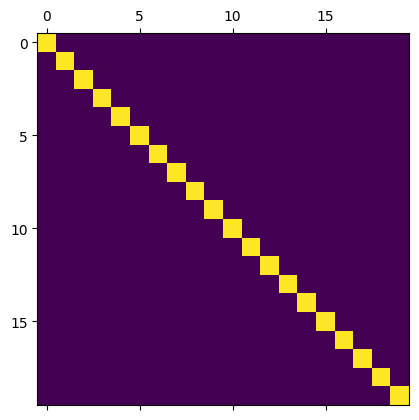

In [180]:
plt.matshow(V @ V.T)

In [181]:
U.shape, S.shape, V.shape

((20, 20), (20,), (20, 1000))

S are called the "singular values" of the matrix and they provide information about the number of underlying dimensions in the data

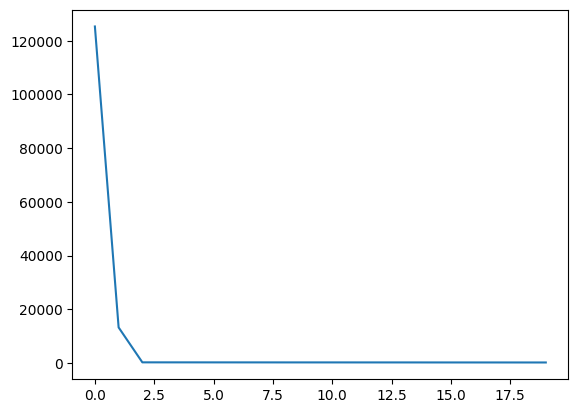

In [182]:
plt.plot(S)

The original matrix can be reconstructed precisely using by multiplying back

In [183]:
recon_data2d = U @ np.diag(S) @ V

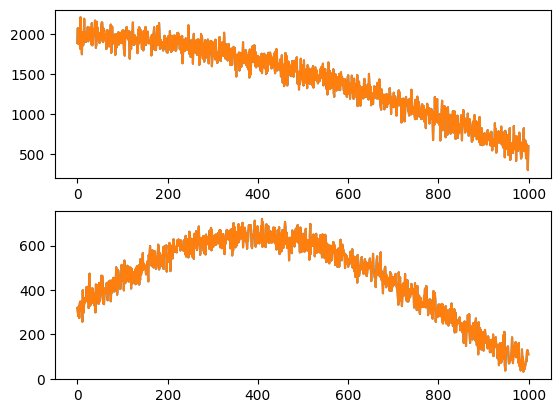

In [187]:
fig, ax = plt.subplots(2)
ax[0].plot(trial_averaged_data[0])
ax[0].plot(recon_data2d[0])

ax[1].plot(trial_averaged_data[10])
ax[1].plot(recon_data2d[10])


One thing that we can already do given this information is reconstruct what we call a "low-rank" representation of the original data. This is done by chopping off (setting to 0) the values of S above the first value

In [188]:
low_rank = np.zeros(S.shape)
low_rank[0] = S[0]
recon_lowrank_data2d = U @ np.diag(low_rank) @ V

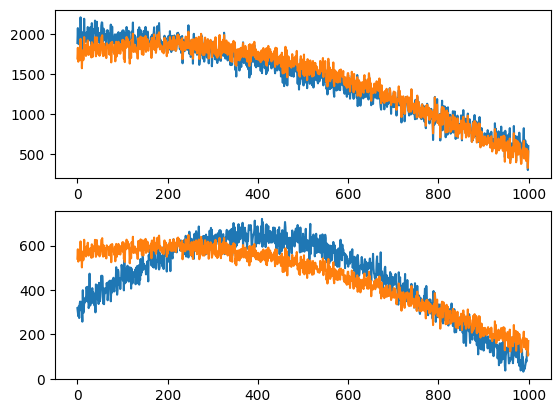

In [189]:
fig, ax = plt.subplots(2)
ax[0].plot(trial_averaged_data[0])
ax[0].plot(recon_lowrank_data2d[0])

ax[1].plot(trial_averaged_data[10])
ax[1].plot(recon_lowrank_data2d[10])


Another (closely related!) approach is provided by the Principal Components analysis 

In [227]:
from sklearn.decomposition import PCA

In [228]:
my_pca = PCA(0.99)

In [229]:
my_pca.fit(trial_averaged_data)

PCA(n_components=0.99)

In [230]:
my_pca.n_components_

2

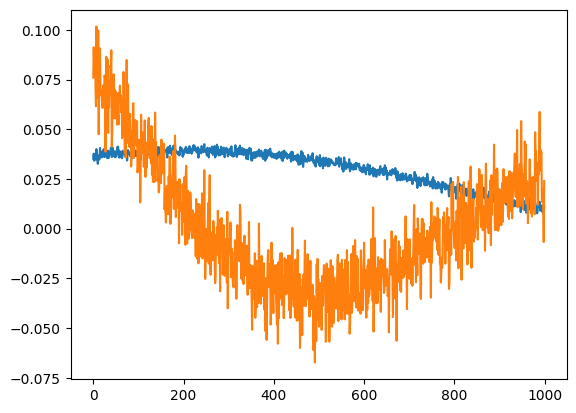

In [231]:
plt.plot(my_pca.components_.T)

In [232]:
trial_averaged_data_reduced = my_pca.fit_transform(trial_averaged_data)

In [233]:
trial_averaged_data_reduced.shape

(20, 2)

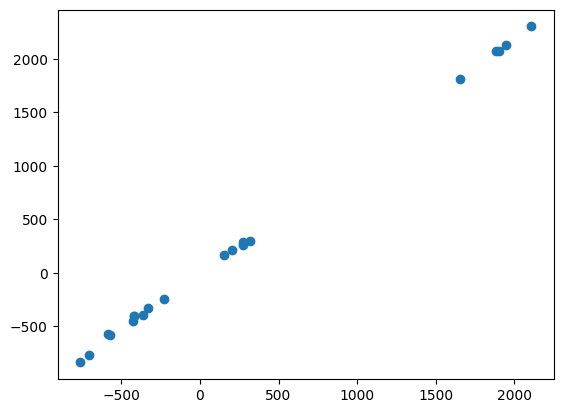

In [234]:
fig, ax = plt.subplots()
ax.scatter(trial_averaged_data[:, 0], trial_averaged_data[:, 1])

In [235]:
my_pca.explained_variance_ratio_

array([0.98972715, 0.01021709])

# Trial-concatenated approach

Here, we extend the time-series and do not average across trials


In [236]:
trial_concat_data = data.reshape(20, -1)

In [237]:
trial_concat_data.shape

(20, 200000)

In [238]:
my_pca.fit(trial_concat_data)

PCA(n_components=0.99)

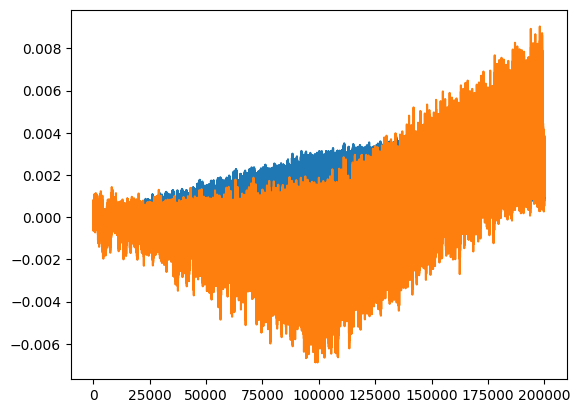

In [239]:
plt.plot(my_pca.components_.T)

In [240]:
my_pca.components_.shape

(2, 200000)

In [241]:
reshape_components = my_pca.components_.reshape((2, 200, 1000))

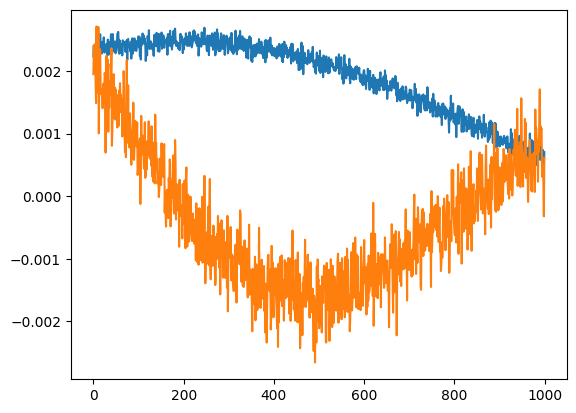

In [242]:
plt.plot(np.mean(reshape_components, 1)[0])
plt.plot(np.mean(reshape_components, 1)[1])

In [243]:
trial_concat_data_reduced = my_pca.fit_transform(trial_concat_data)

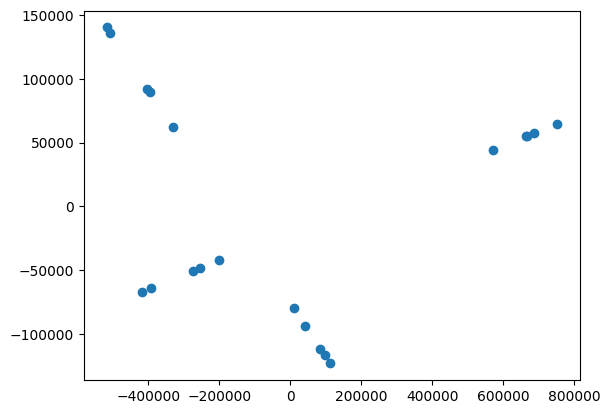

In [244]:
fig, ax = plt.subplots()
ax.scatter(trial_concat_data_reduced[:, 0], trial_concat_data_reduced[:, 1])

In [245]:
my_pca.explained_variance_ratio_

array([0.95418059, 0.03715929])

# Tensor decomposition

Decompose in all three directions at once

In [246]:
from tensorly.decomposition import parafac

In [253]:
tca = parafac(data, 2)

In [254]:
F1, F2, F3 = tca.factors

In [255]:
F1.shape, F2.shape, F3.shape

((20, 2), (200, 2), (1000, 2))

<BarContainer object of 20 artists>

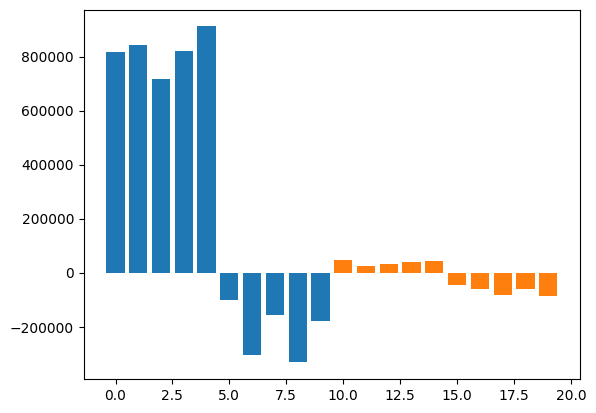

In [256]:
fig, ax = plt.subplots()
ax.bar(range(20), F1[:, 0])
ax.bar(range(20), F1[:, 1])

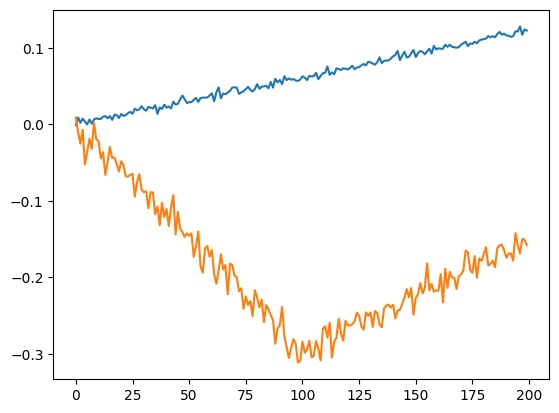

In [257]:
fig, ax = plt.subplots()
ax.plot(F2[:, 0])
ax.plot(F2[:, 1])

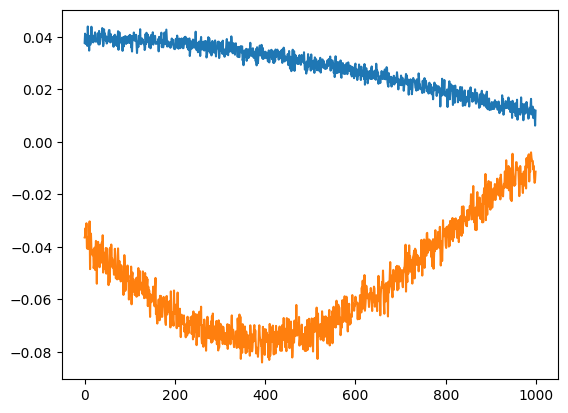

In [258]:
fig, ax = plt.subplots()
ax.plot(F3[:, 0])
ax.plot(F3[:, 1])

In [263]:
transformed = tca.to_tensor()

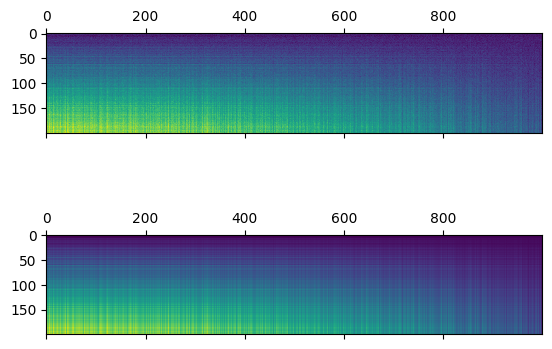

In [273]:
fig, ax = plt.subplots(2)
ax[0].matshow(data[0])
ax[1].matshow(transformed[0])

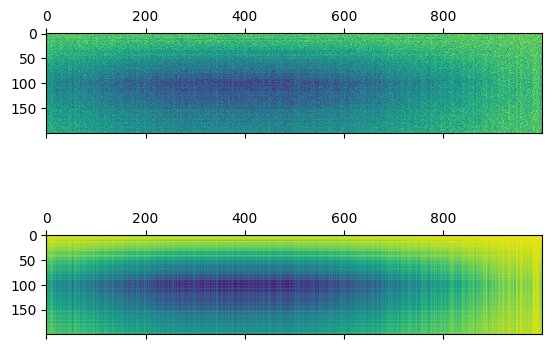

In [274]:
fig, ax = plt.subplots(2)
ax[0].matshow(data[15])
ax[1].matshow(transformed[15])